# LSTM

## 0. Data Load

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir('/content/drive/MyDrive/기상청/데이터')

In [3]:
import numpy as np
import pandas as pd
import datetime
from datetime import timedelta
from tqdm.notebook import tqdm
tqdm.pandas()

import random
from functools import reduce

import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
%matplotlib inline

rc('font', family='MalgunGothic')
plt.rcParams['axes.unicode_minus'] = False

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.metrics import mean_squared_error

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [4]:
df_st = pd.read_csv('st_high_0616.csv', encoding='CP949')

In [6]:
df_st.head(2)

,date,sex,big_cat,sm_cat,qty,ratio,오늘날씨,미세먼지,오늘 비,기상정보,태풍정보,avg_ta,max_ta,min_ta,rn_day,rn_hr1,avg_ws,PM10,PM25,hm_max,sum_ss_hr,max_pa,공휴일여부,주말여부,연_2019,월_2,월_3,월_4,월_5,월_6,월_7,월_8,월_9,월_10,월_11,월_12,분기_2,분기_3,분기_4,요일_1,요일_2,요일_3,요일_4,요일_5,요일_6,계절_1,계절_2,계절_3,age_20,age_30,age_40,age_50
0,2018-01-01,1,냉난방가전,가스온수기,0.0,10.52631,10.69387,4.09137,0.0,0.00000,0.04440,0.885198,5.464146,-2.88074,0.0,0.0,2.157094,44.015611,21.477208,61.923313,52.276365,1020.592385,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0
1,2018-01-01,1,냉난방가전,가스온수기,0.0,19.04761,12.42969,6.35294,0.0,0.51282,0.42417,0.885198,5.464146,-2.88074,0.0,0.0,2.157094,44.015611,21.477208,61.923313,52.276365,1020.592385,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0


## 1. Data Preprocessing

In [5]:
df_lstm = df_st.copy()

In [6]:
# 일자별 데이터 생성
df_lstm = df_lstm.groupby(['date','sm_cat']).sum().reset_index()

In [7]:
# 인덱스를 date로
df_lstm.index = pd.to_datetime(df_lstm['date'], format='%Y-%m-%d')

In [50]:
df_lstm.head(2)

,date,sm_cat,sex,qty,ratio,오늘날씨,미세먼지,오늘 비,기상정보,태풍정보,avg_ta,max_ta,min_ta,rn_day,rn_hr1,avg_ws,PM10,PM25,hm_max,sum_ss_hr,max_pa,공휴일여부,주말여부,연_2019,월_2,월_3,월_4,월_5,월_6,월_7,월_8,월_9,월_10,월_11,월_12,분기_2,분기_3,분기_4,요일_1,요일_2,요일_3,요일_4,요일_5,요일_6,계절_1,계절_2,계절_3,age_20,age_30,age_40,age_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-01-01,2018-01-01,가스온수기,0.444444,0.0,15.427426,12.996921,5.326573,0.168782,1.024903,0.184560,0.885198,5.464146,-2.88074,0.0,0.0,2.157094,44.015611,21.477208,61.923313,52.276365,1020.592385,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.222222,0.222222,0.222222,0.111111
2018-01-01,2018-01-01,가자미,0.500000,2.1,2.188916,12.866309,5.247266,0.273855,1.013322,0.166104,0.885198,5.464146,-2.88074,0.0,0.0,2.157094,44.015611,21.477208,61.923312,52.276365,1020.592385,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.200000,0.200000,0.200000,0.200000


In [10]:
df_lstm.columns

Index(['date', 'sex', 'big_cat', 'sm_cat', 'qty', 'ratio', '오늘날씨', '미세먼지',
       '오늘 비', '기상정보', '태풍정보', 'avg_ta', 'max_ta', 'min_ta', 'rn_day',
       'rn_hr1', 'avg_ws', 'PM10', 'PM25', 'hm_max', 'sum_ss_hr', 'max_pa',
       '공휴일여부', '주말여부', '연_2019', '월_2', '월_3', '월_4', '월_5', '월_6', '월_7',
       '월_8', '월_9', '월_10', '월_11', '월_12', '분기_2', '분기_3', '분기_4', '요일_1',
       '요일_2', '요일_3', '요일_4', '요일_5', '요일_6', '계절_1', '계절_2', '계절_3',
       'age_20', 'age_30', 'age_40', 'age_50'],
      dtype='object')

In [51]:
df_lstm.sm_cat.unique()

array(['가스온수기', '가자미', '갈비/찜/바비큐용 돈육', '건강즙/녹용', '건어물 멸치', '건어물 진미채',
       '건어물 황태', '건자두', '견과류 마카다미아', '견과류 잣/은행', '견과류 캐슈넛', '견과류 호두',
       '공기청정기', '곶감/반건시', '과일류', '기능성 링클케어 화장품', '기타 농산물', '기타 한방/환제품',
       '나물', '남성 스킨', '남성 에센스', '남성 크림', '네일리무버', '네일케어', '느타리버섯',
       '립앤아이 리무버', '마늘/생강', '메이크업 박스', '명태/동태', '무/배추', '밀크티/티라떼',
       '바디케어용 때비누', '바디케어용 슬리밍', '반건조고구마', '반찬류', '베이스 메이크업 세트',
       '베이스 메이크업용 CC크림', '베이스 메이크업용 메이크업베이스', '베이스 메이크업용 컨실러', '부추',
       '뷰티용 기름종이', '뷰티용 면봉/귀이개', '뷰티용 뷰러', '브로콜리/셀러리', '비타민', '삼치',
       '색조 메이크업 립틴트', '색조 메이크업 볼터치', '색조 메이크업 속눈썹영양제', '색조 메이크업 쉐딩/하이라이터',
       '생닭/닭부분육', '소고기 등심/안심', '소고기 육회', '수산 생물', '스킨케어 수면팩', '스킨케어 필오프팩',
       '양배추/양상추', '어란(생선알)', '어린이영양제', '어린잎/새싹채소', '오징어', '요거트/발효유',
       '원두커피', '인삼/수삼/산삼', '절임배추/김치속', '차 선물세트', '차/곡물 음료', '천장형 에어컨',
       '초코우유', '칼슘/철분 영양제', '콜라겐/코큐텐 영양제', '클렌징 로션', '클렌징 크림', '클렌징 티슈',
       '클렌징 폼', '파김치', '팩도구', '표고버섯', '풋워시/스크럽', '풋패치', '한우육', '해조류 다시마',
       '핸드워시/스크

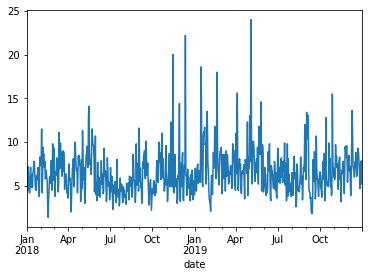

In [53]:
df_lstm[df_lstm['sm_cat']=='견과류 호두']['qty'].plot()

In [8]:
# 각 소분류에 대하여
df_ex = df_lstm[df_lstm['sm_cat']=='견과류 호두']

In [9]:
# 사용할 변수만 선택
df_use = df_ex[['qty', 'ratio','오늘날씨','미세먼지','오늘 비', '기상정보', '태풍정보', 'avg_ta', 'max_ta', 'min_ta', 'rn_day',
       'rn_hr1', 'avg_ws', 'PM10', 'PM25', 'hm_max', 'sum_ss_hr', 'max_pa', '공휴일여부', '주말여부']]

In [56]:
df_use.head(2)

,qty,ratio,오늘날씨,미세먼지,오늘 비,기상정보,태풍정보,avg_ta,max_ta,min_ta,rn_day,rn_hr1,avg_ws,PM10,PM25,hm_max,sum_ss_hr,max_pa,공휴일여부,주말여부
date,,,,,,,,,,,,,,,,,,,,
2018-01-01,4.5,28.451096,12.866309,5.247266,0.273855,1.013322,0.166104,0.885198,5.464146,-2.880740,0.0,0.0,2.157094,44.015611,21.477208,61.923312,52.276365,1020.592385,1.0,0.0
2018-01-02,7.2,31.360985,15.862925,4.807639,0.078435,1.497471,0.181647,1.208896,6.014385,-3.135167,0.0,0.0,1.903604,59.179487,33.836826,74.169781,37.996677,1021.524802,0.0,0.0


In [102]:
df_use.columns

Index(['qty', 'ratio', '오늘날씨', '미세먼지', '오늘 비', '기상정보', '태풍정보', 'avg_ta',
       'max_ta', 'min_ta', 'rn_day', 'rn_hr1', 'avg_ws', 'PM10', 'PM25',
       'hm_max', 'sum_ss_hr', 'max_pa', '공휴일여부', '주말여부'],
      dtype='object')

In [10]:
# 스케일링
scaler = MinMaxScaler(feature_range=(0, 1))
df_scale = scaler.fit_transform(df_use)

In [11]:
# specify the number of lag hours
n_hours = 3
n_features = 19

In [12]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [13]:
# (n) x (m) -> (n-1) x (2m)
# to include the current and the 1-step look-back values
df_reframe = series_to_supervised(df_scale, n_hours, 1)
print(df_reframe.shape)
df_reframe.head(2)

(727, 80)


,var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var6(t-3),var7(t-3),var8(t-3),var9(t-3),var10(t-3),var11(t-3),var12(t-3),var13(t-3),var14(t-3),var15(t-3),var16(t-3),var17(t-3),var18(t-3),var19(t-3),var20(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var6(t-2),var7(t-2),var8(t-2),var9(t-2),var10(t-2),var11(t-2),var12(t-2),var13(t-2),var14(t-2),var15(t-2),var16(t-2),var17(t-2),var18(t-2),var19(t-2),var20(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),var11(t-1),var12(t-1),var13(t-1),var14(t-1),var15(t-1),var16(t-1),var17(t-1),var18(t-1),var19(t-1),var20(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t),var8(t),var9(t),var10(t),var11(t),var12(t),var13(t),var14(t),var15(t),var16(t),var17(t),var18(t),var19(t),var20(t)
3,0.137168,0.181286,0.079963,0.051023,0.002881,0.00231,0.001910,0.282275,0.293697,0.273628,0.0,0.0,0.275783,0.300410,0.211566,0.380654,0.661924,0.975454,1.0,0.0,0.256637,0.226672,0.113014,0.046317,0.000825,0.007190,0.002088,0.290785,0.307831,0.266960,0.0,0.0,0.217126,0.427235,0.356830,0.596928,0.481114,0.980279,0.0,0.0,0.247788,0.167647,0.082063,0.019729,0.001231,0.011883,0.001744,0.238009,0.236466,0.254262,0.0,0.0,0.383724,0.206255,0.173547,0.334510,0.673833,0.989349,0.0,0.0,0.256637,0.180354,0.066988,0.020696,0.001120,0.011541,0.001859,0.230726,0.213595,0.227607,0.000000,0.00000,0.203039,0.255830,0.229996,0.416653,0.426800,0.980356,0.0,0.0
4,0.256637,0.226672,0.113014,0.046317,0.000825,0.00719,0.002088,0.290785,0.307831,0.266960,0.0,0.0,0.217126,0.427235,0.356830,0.596928,0.481114,0.980279,0.0,0.0,0.247788,0.167647,0.082063,0.019729,0.001231,0.011883,0.001744,0.238009,0.236466,0.254262,0.0,0.0,0.383724,0.206255,0.173547,0.334510,0.673833,0.989349,0.0,0.0,0.256637,0.180354,0.066988,0.020696,0.001120,0.011541,0.001859,0.230726,0.213595,0.227607,0.0,0.0,0.203039,0.255830,0.229996,0.416653,0.426800,0.980356,0.0,0.0,0.137168,0.204422,0.062533,0.029484,0.002674,0.005236,0.004388,0.274374,0.283160,0.289555,0.004387,0.00553,0.304440,0.318276,0.320964,0.554148,0.511586,0.944061,0.0,0.0


In [15]:
# split into train and test sets
values = df_reframe.values
n_train_hours = 730 - 60
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(670, 57) 670 (670,)
(670, 3, 19) (670,) (57, 3, 19) (57,)


## 2. LSTM

Epoch 1/50
10/10 - 18s - loss: 0.2551 - val_loss: 0.2493
Epoch 2/50
10/10 - 0s - loss: 0.1095 - val_loss: 0.1770
Epoch 3/50
10/10 - 0s - loss: 0.1086 - val_loss: 0.2482
Epoch 4/50
10/10 - 0s - loss: 0.0895 - val_loss: 0.2566
Epoch 5/50
10/10 - 0s - loss: 0.0810 - val_loss: 0.2187
Epoch 6/50
10/10 - 0s - loss: 0.0820 - val_loss: 0.2110
Epoch 7/50
10/10 - 0s - loss: 0.0798 - val_loss: 0.2116
Epoch 8/50
10/10 - 0s - loss: 0.0759 - val_loss: 0.1998
Epoch 9/50
10/10 - 0s - loss: 0.0746 - val_loss: 0.1920
Epoch 10/50
10/10 - 0s - loss: 0.0730 - val_loss: 0.1870
Epoch 11/50
10/10 - 0s - loss: 0.0709 - val_loss: 0.1796
Epoch 12/50
10/10 - 0s - loss: 0.0692 - val_loss: 0.1710
Epoch 13/50
10/10 - 0s - loss: 0.0682 - val_loss: 0.1675
Epoch 14/50
10/10 - 0s - loss: 0.0663 - val_loss: 0.1606
Epoch 15/50
10/10 - 0s - loss: 0.0652 - val_loss: 0.1554
Epoch 16/50
10/10 - 0s - loss: 0.0636 - val_loss: 0.1464
Epoch 17/50
10/10 - 0s - loss: 0.0630 - val_loss: 0.1426
Epoch 18/50
10/10 - 0s - loss: 0.0618 -

findfont: Font family ['MalgunGothic'] not found. Falling back to DejaVu Sans.


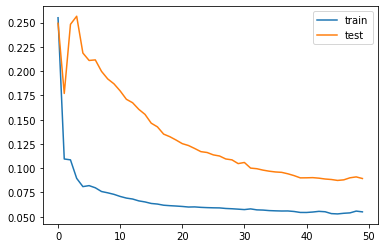

In [16]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [17]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, -(n_features):]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -(n_features):]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 2.691


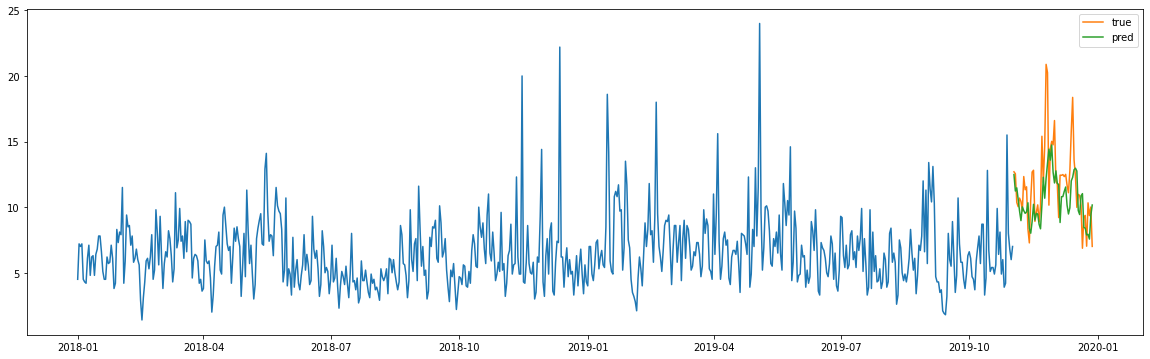

In [38]:
plt.figure(figsize=(20,6))
plt.plot(df_use.iloc[:n_train_hours,:]['qty'])
plt.plot(df_use.iloc[n_train_hours:-n_hours,:].index, inv_y, label='true')
plt.plot(df_use.iloc[n_train_hours:-n_hours,:].index, inv_yhat, label='pred')
plt.legend()
plt.show()

* 코드: https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/
* 설명: https://qwerty1434.github.io/%EB%8B%A4%EC%A4%91%EB%B3%80%EC%88%98%EC%9D%98-%ED%83%80%EC%9E%84%EC%8B%9C%EB%A6%AC%EC%A6%88-LSTM%EC%97%B0%EC%8A%B5
* 디버깅: https://datascience.stackexchange.com/questions/22488/value-error-operands-could-not-be-broadcast-together-with-shapes-lstm

## 3. Function

In [ ]:
df_lstm = df_st.copy()
df_lstm = df_lstm.groupby(['date','sm_cat']).sum().reset_index()

In [ ]:
def MAPE(y_test, y_pred):
	return np.mean(np.abs((y_test - y_pred) / y_test)) * 100 

In [ ]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [39]:
def sm_cat_lstm(smcat):
    print('소분류: ', smcat)
    ## 데이터 전처리 ##
    # 각 소분류에 대하여
    df_ex = df_lstm[df_lstm['sm_cat']==smcat]
    # 사용할 변수만 선택
    df_use = df_ex[['qty', 'ratio','오늘날씨','미세먼지','오늘 비', '기상정보', '태풍정보', 'avg_ta', 'max_ta', 'min_ta', 'rn_day',
                    'rn_hr1', 'avg_ws', 'PM10', 'PM25', 'hm_max', 'sum_ss_hr', 'max_pa', '공휴일여부', '주말여부']]
    # 스케일링
    df_scale = scaler.fit_transform(df_use)
    # 데이터 프레임
    n_hours = 3; n_features = 19
    df_reframe = series_to_supervised(df_scale, n_hours, 1)
    # 트테분리
    values = df_reframe.values
    n_train_hours = 730 - 60
    train = values[:n_train_hours, :]
    test = values[n_train_hours:, :]
    # split into input and outputs
    n_obs = n_hours * n_features
    train_X, train_y = train[:, :n_obs], train[:, -n_features]
    test_X, test_y = test[:, :n_obs], test[:, -n_features]
    print(train_X.shape, len(train_X), train_y.shape)
    # reshape input to be 3D [samples, timesteps, features]
    train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
    test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
    print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

    ## 모델링 ##
    # design network
    model = Sequential()
    model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam')
    # fit network
    history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
    # plot history
    plt.figure(figsize=(15,6))
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    plt.title('loss')
    plt.show()
    # make a prediction
    yhat = model.predict(test_X)
    test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))
    # invert scaling for forecast
    inv_yhat = np.concatenate((yhat, test_X[:, -(n_features):]), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,0]
    # invert scaling for actual
    test_y = test_y.reshape((len(test_y), 1))
    inv_y = np.concatenate((test_y, test_X[:, -(n_features):]), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:,0]
    # calculate RMSE
    mape = MAPE(inv_y, inv_yhat)
    
    # plot predict
    plt.figure(figsize=(15,6))
    plt.plot(df_use.iloc[:n_train_hours,:]['qty'])
    plt.plot(df_use.iloc[n_train_hours:-n_hours,:].index, inv_y, label='true')
    plt.plot(df_use.iloc[n_train_hours:-n_hours,:].index, inv_yhat, label='pred')
    plt.legend()
    plt.show()
    print('Test MAPE: %.3f' % mape)
    print('=========='*10)

소분류:  견과류 호두
(670, 57) 670 (670,)
(670, 3, 19) (670,) (57, 3, 19) (57,)
Epoch 1/50
10/10 - 3s - loss: 0.0985 - val_loss: 0.2328
Epoch 2/50
10/10 - 0s - loss: 0.1086 - val_loss: 0.2689
Epoch 3/50
10/10 - 0s - loss: 0.0955 - val_loss: 0.2647
Epoch 4/50
10/10 - 0s - loss: 0.0849 - val_loss: 0.2362
Epoch 5/50
10/10 - 0s - loss: 0.0871 - val_loss: 0.2425
Epoch 6/50
10/10 - 0s - loss: 0.0798 - val_loss: 0.2267
Epoch 7/50
10/10 - 0s - loss: 0.0782 - val_loss: 0.2199
Epoch 8/50
10/10 - 0s - loss: 0.0749 - val_loss: 0.2094
Epoch 9/50
10/10 - 0s - loss: 0.0722 - val_loss: 0.1987
Epoch 10/50
10/10 - 0s - loss: 0.0690 - val_loss: 0.1861
Epoch 11/50
10/10 - 0s - loss: 0.0670 - val_loss: 0.1780
Epoch 12/50
10/10 - 0s - loss: 0.0641 - val_loss: 0.1630
Epoch 13/50
10/10 - 0s - loss: 0.0626 - val_loss: 0.1520
Epoch 14/50
10/10 - 0s - loss: 0.0617 - val_loss: 0.1443
Epoch 15/50
10/10 - 0s - loss: 0.0616 - val_loss: 0.1373
Epoch 16/50
10/10 - 0s - loss: 0.0610 - val_loss: 0.1305
Epoch 17/50
10/10 - 0s - 

findfont: Font family ['MalgunGothic'] not found. Falling back to DejaVu Sans.


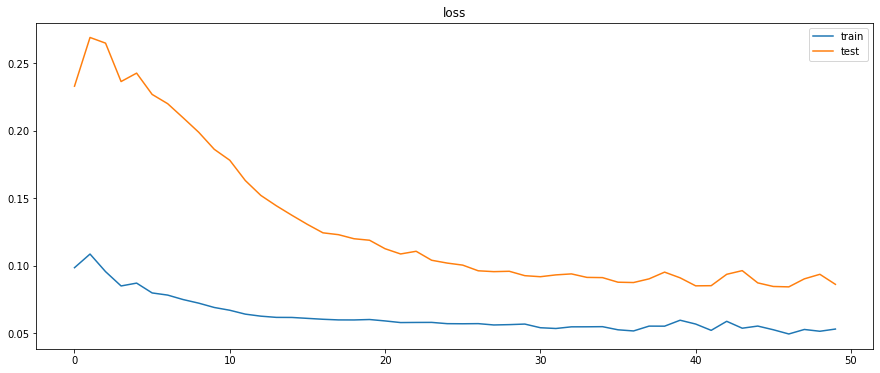

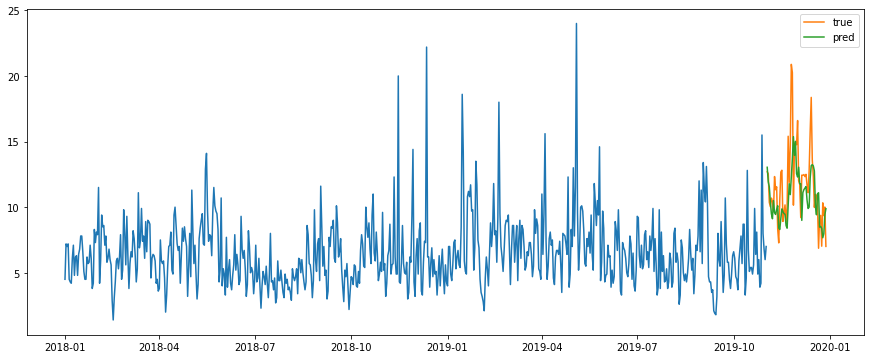

Test RMSE: 2.613


In [40]:
sm_cat_lstm('견과류 호두')